In [1]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    cleaned_code = re.sub(r'".*?"', '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [2]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [3]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [4]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/valid.jsonl", "r") as f:
    comment_dataset = [json.loads(line) for line in f.readlines()]

with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/codebase.jsonl", "r") as f:
    code_dataset = [json.loads(line) for line in f.readlines()]


In [5]:
nl_urls=[]
code_urls=[]
for comment_example in comment_dataset:
    nl_urls.append(comment_example['url'])
    
for code_example in code_dataset:
    code_urls.append(code_example['url'])

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
code_cls_tokens_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_valid/Epoch_1/valid_code_cls_tokens.npy'
nl_cls_tokens_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_valid/Epoch_1/valid_nl_cls_tokens.npy'

nl_cls_tokens = np.load(nl_cls_tokens_path)
code_cls_tokens = np.load(code_cls_tokens_path)

similarities = cosine_similarity(nl_cls_tokens, code_cls_tokens)

# 为每个comment找到最相似的code，并进行排序
most_similar_code_indices = np.argsort(-similarities, axis=1)  # 降序排序


In [7]:
retri_code_cls_tokens_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_valid_retri/Epoch_1/valid_code_cls_tokens_retri.npy'
retri_nl_cls_tokens_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_valid_retri/Epoch_1/valid_nl_cls_tokens_retri.npy'

retri_nl_cls_tokens = np.load(retri_nl_cls_tokens_path)
retri_code_cls_tokens = np.load(retri_code_cls_tokens_path)

retri_similarities = cosine_similarity(retri_nl_cls_tokens, retri_code_cls_tokens)

# 为每个comment找到最相似的code，并进行排序
retri_most_similar_code_indices = np.argsort(-retri_similarities, axis=1)  # 降序排序

In [8]:
# 假设 most_similar_code_indices 的形状为 (320, n)
retri_num_rows = retri_most_similar_code_indices.shape[0]

retri_ranks=[]

# 遍历每一行，检查前十个值是否包含当前的行索引
for row_idx in range(retri_num_rows):
    rank = 0
    top_10_indices = retri_most_similar_code_indices[row_idx, :1000]  # 获取前十个值
    nl_url = nl_urls[row_idx]  # 当前 comment 的 URL
    matched = False

    # 遍历前十个索引，检查是否有相同的 URL
    for idx in top_10_indices:
        rank+=1
        if code_urls[idx] == nl_url:
            matched = True
            break

    # 输出是否匹配
    if matched:
        retri_ranks.append(1/rank)
        # print(f"行 {row_idx} 的前十个最相似代码中包含相同的 URL，排名为 {rank}。")
    else:
        retri_ranks.append(0)

行 0 的前十个最相似代码中包含相同的 URL，排名为 16。
行 1 的前十个最相似代码中包含相同的 URL，排名为 1。
行 2 的前十个最相似代码中包含相同的 URL，排名为 7。
行 3 的前十个最相似代码中包含相同的 URL，排名为 1。
行 4 的前十个最相似代码中包含相同的 URL，排名为 11。
行 5 的前十个最相似代码中包含相同的 URL，排名为 68。
行 7 的前十个最相似代码中包含相同的 URL，排名为 1。
行 8 的前十个最相似代码中包含相同的 URL，排名为 2。
行 9 的前十个最相似代码中包含相同的 URL，排名为 2。
行 10 的前十个最相似代码中包含相同的 URL，排名为 2。
行 11 的前十个最相似代码中包含相同的 URL，排名为 362。
行 12 的前十个最相似代码中包含相同的 URL，排名为 1。
行 13 的前十个最相似代码中包含相同的 URL，排名为 1。
行 14 的前十个最相似代码中包含相同的 URL，排名为 1。
行 15 的前十个最相似代码中包含相同的 URL，排名为 1。
行 16 的前十个最相似代码中包含相同的 URL，排名为 168。
行 18 的前十个最相似代码中包含相同的 URL，排名为 3。
行 19 的前十个最相似代码中包含相同的 URL，排名为 214。
行 20 的前十个最相似代码中包含相同的 URL，排名为 8。
行 21 的前十个最相似代码中包含相同的 URL，排名为 1。
行 22 的前十个最相似代码中包含相同的 URL，排名为 1。
行 23 的前十个最相似代码中包含相同的 URL，排名为 2。
行 24 的前十个最相似代码中包含相同的 URL，排名为 2。
行 25 的前十个最相似代码中包含相同的 URL，排名为 1。
行 26 的前十个最相似代码中包含相同的 URL，排名为 1。
行 27 的前十个最相似代码中包含相同的 URL，排名为 59。
行 28 的前十个最相似代码中包含相同的 URL，排名为 6。
行 29 的前十个最相似代码中包含相同的 URL，排名为 3。
行 30 的前十个最相似代码中包含相同的 URL，排名为 1。
行 31 的前十个最相似代码中包含相同的 URL，排名为 1。
行 32 的前十个最相似代码中包含相同的 URL，排名为 27。
行 33 的

In [20]:
# 假设 most_similar_code_indices 的形状为 (320, n)
num_rows = most_similar_code_indices.shape[0]

ranks=[]

# 遍历每一行，检查前十个值是否包含当前的行索引
for row_idx in range(num_rows):
    rank = 0
    top_10_indices = most_similar_code_indices[row_idx, :1000]  # 获取前十个值
    nl_url = nl_urls[row_idx]  # 当前 comment 的 URL
    matched = False

    # 遍历前十个索引，检查是否有相同的 URL
    for idx in top_10_indices:
        rank+=1
        if code_urls[idx] == nl_url:
            matched = True
            break

    # 输出是否匹配
    if matched:
        ranks.append(1/rank)
        # print(f"行 {row_idx} 的前十个最相似代码中包含相同的 URL，排名为 {rank}。")
    else:
        ranks.append(0)


行 0 的前十个最相似代码中包含相同的 URL，排名为 3。
行 1 的前十个最相似代码中包含相同的 URL，排名为 19。
行 2 的前十个最相似代码中包含相同的 URL，排名为 27。
行 3 的前十个最相似代码中包含相同的 URL，排名为 7。
行 4 的前十个最相似代码中包含相同的 URL，排名为 1。
行 5 的前十个最相似代码中包含相同的 URL，排名为 2。
行 7 的前十个最相似代码中包含相同的 URL，排名为 132。
行 8 的前十个最相似代码中包含相同的 URL，排名为 165。
行 9 的前十个最相似代码中包含相同的 URL，排名为 55。
行 10 的前十个最相似代码中包含相同的 URL，排名为 1。
行 12 的前十个最相似代码中包含相同的 URL，排名为 2。
行 13 的前十个最相似代码中包含相同的 URL，排名为 1。
行 14 的前十个最相似代码中包含相同的 URL，排名为 3。
行 15 的前十个最相似代码中包含相同的 URL，排名为 557。
行 17 的前十个最相似代码中包含相同的 URL，排名为 168。
行 18 的前十个最相似代码中包含相同的 URL，排名为 35。
行 19 的前十个最相似代码中包含相同的 URL，排名为 700。
行 20 的前十个最相似代码中包含相同的 URL，排名为 84。
行 21 的前十个最相似代码中包含相同的 URL，排名为 4。
行 22 的前十个最相似代码中包含相同的 URL，排名为 1。
行 23 的前十个最相似代码中包含相同的 URL，排名为 257。
行 24 的前十个最相似代码中包含相同的 URL，排名为 657。
行 25 的前十个最相似代码中包含相同的 URL，排名为 436。
行 26 的前十个最相似代码中包含相同的 URL，排名为 1。
行 28 的前十个最相似代码中包含相同的 URL，排名为 83。
行 29 的前十个最相似代码中包含相同的 URL，排名为 1。
行 30 的前十个最相似代码中包含相同的 URL，排名为 1。
行 31 的前十个最相似代码中包含相同的 URL，排名为 6。
行 32 的前十个最相似代码中包含相同的 URL，排名为 99。
行 33 的前十个最相似代码中包含相同的 URL，排名为 2。
行 35 的前十个最相似代码中包含相同的 URL，排

In [21]:
np.mean(ranks)

0.2944451496244765

In [11]:
np.mean(retri_ranks)

0.6003127598229206

In [12]:
# 计算增加和减小的差值，并存储索引和值的元组
increase_diff = [(i, retri_ranks[i] - ranks[i]) for i in range(len(retri_ranks))]
decrease_diff = [(i, ranks[i] - retri_ranks[i]) for i in range(len(retri_ranks))]

# 对增加和减小的差值进行排序，并分别取前五名
top_5_increase = sorted(increase_diff, key=lambda x: x[1], reverse=True)[:50]
top_5_decrease = sorted(decrease_diff, key=lambda x: x[1], reverse=True)[:50]

# 输出结果
print("增加最大的前五名索引和差值:")
for idx, diff in top_5_increase:
    print(f"Index: {idx}, Difference: {diff}, retri_rank: {retri_ranks[idx]}, rank: {ranks[idx]}")

print("\n减小最大的前五名索引和差值:")
for idx, diff in top_5_decrease:
    print(f"Index: {idx}, Difference: {diff}, retri_rank: {retri_ranks[idx]}, rank: {ranks[idx]}")

增加最大的前五名索引和差值:
Index: 3, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 15, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 94, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 236, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 271, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 272, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 404, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 458, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 587, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 589, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 902, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 971, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 993, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1006, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1121, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1219, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1265, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1425, Difference: 1.0, retri_rank: 1.0, rank: 0
Index: 1476,

In [13]:
# 统计 difference 大于 0 的元素数量
count_greater_than_zero = sum(1 for _, diff in increase_diff if diff > 0)

# 输出结果
print(f"大于 0 的元素个数: {count_greater_than_zero}")

大于 0 的元素个数: 8579


In [14]:
# 统计 difference 大于 0 的元素数量
count_greater_than_zero = sum(1 for _, diff in increase_diff if diff < 0)

# 输出结果
print(f"大于 0 的元素个数: {count_greater_than_zero}")

大于 0 的元素个数: 1744


In [26]:
mrr_index = 3447  
print(most_similar_code_indices[mrr_index][:10])
print(similarities[mrr_index][most_similar_code_indices[mrr_index][:10]])
print(np.max(similarities[mrr_index]), np.min(similarities[mrr_index]))

print(retri_most_similar_code_indices[mrr_index][:10])
print(retri_similarities[mrr_index][retri_most_similar_code_indices[mrr_index][:10]])
print(np.max(retri_similarities[mrr_index]), np.min(retri_similarities[mrr_index]))

[16451 15278 10713 13123 14075  5271 16972 13335  9559 28891]
[0.7466741  0.7060146  0.7000915  0.6924775  0.69090617 0.6856968
 0.6852168  0.68490523 0.6832833  0.68006325]
0.7466741 0.23659584
[25827 28067 31601 19967 40364 40821 43223 24601  8651 40987]
[0.6322714  0.5385738  0.53111625 0.52809304 0.5208099  0.51400983
 0.509244   0.50696105 0.5045443  0.5041095 ]
0.6322714 -0.20955788


In [16]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/features/valid_tokenized_code_tokens.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/temp_featrues/valid_tokenized_nl_tokens.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    nl_tokens_data = json.load(f)

In [27]:
code_ind = retri_most_similar_code_indices[mrr_index][0]
comment_ind = mrr_index
# code_ind = 36111
# comment_ind = 11773
# comment_id = comment_ind

In [28]:
print(comment_dataset[comment_ind]['docstring'])

Convert a solution to medium.

    Arguments
    ---------
    exchanges : list of cobra.reaction
        The exchange reactions to consider.
    tolerance : positive double
        The absolute tolerance for fluxes. Fluxes with an absolute value
        smaller than this number will be ignored.
    exports : bool
        Whether to return export fluxes as well.

    Returns
    -------
    pandas.Series
        The "medium", meaning all active import fluxes in the solution.


In [29]:
print(code_dataset[code_ind]['code'])

def _as_medium(exchanges, tolerance=1e-6, exports=False):
    """Convert a solution to medium.

    Arguments
    ---------
    exchanges : list of cobra.reaction
        The exchange reactions to consider.
    tolerance : positive double
        The absolute tolerance for fluxes. Fluxes with an absolute value
        smaller than this number will be ignored.
    exports : bool
        Whether to return export fluxes as well.

    Returns
    -------
    pandas.Series
        The "medium", meaning all active import fluxes in the solution.
    """
    LOGGER.debug("Formatting medium.")
    medium = pd.Series()
    for rxn in exchanges:
        export = len(rxn.reactants) == 1
        flux = rxn.flux
        if abs(flux) < tolerance:
            continue
        if export:
            medium[rxn.id] = -flux
        elif not export:
            medium[rxn.id] = flux
    if not exports:
        medium = medium[medium > 0]

    return medium


In [30]:
print(code_dataset[most_similar_code_indices[mrr_index][0]]['code'])

def _convert(value, to_type, default=None):
    """Convert value to to_type, returns default if fails."""
    try:
        return default if value is None else to_type(value)
    except ValueError:
        # If value could not be converted
        return default


In [246]:
code_data = code_tokens_data[code_ind]
comment_data = nl_tokens_data[comment_ind]

In [247]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/code_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(code_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        f_out.write(str(code_data[i]))
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        code_length = i
        break

print("处理完成！")

处理完成！


In [248]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/comment_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# comment_data = ['<s>'] + comment_dataset[comment_id]["docstring_tokens"] + ['</s>']
# 遍历列表的每一项
for i, token_list in enumerate(comment_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        f_out.write(comment_data[i])
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        comment_length = i
        break

print("处理完成！")

处理完成！


In [249]:
import numpy as np

# 文件路径
nl_tokens_path = '/home/yiming/cophi/training_dynamic/features/aa_possim/valid_nl_tokens_aa.npy'
code_tokens_path = '/home/yiming/cophi/training_dynamic/features/aa_possim/valid_code_tokens_aa.npy'
output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'

# 获取 n 和 m
n = comment_length
m = code_length

# 读取nl_tokens.npy中的前n条数据
nl_tokens = np.load(nl_tokens_path)[0][:n]

# 读取code_tokens.npy中的前m条数据
code_tokens = np.load(code_tokens_path)[0][:m]

# 拼接两部分数据
combined_data = np.concatenate((nl_tokens, code_tokens))
print(combined_data.shape)

# 将拼接后的数据保存到train_data.npy
np.save(output_path, combined_data)

# print(f"拼接完成！数据已保存到 {output_path}")


(43, 768)


In [250]:
import json

# 文件路径
index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/code_index.json'
index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/code_index.json'

# 生成从0到n+m-1的索引
indices = list(range(m))

# 将索引保存到index.json中
with open(index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {index_output_path}")

with open(index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {index_output_path_2}")


In [251]:
# 文件路径
comment_index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/comment_index.json'
comment_index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/comment_index.json'

# 生成从0到n+m-1的索引
indices = list(range(n))

# 将索引保存到index.json中
with open(comment_index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {comment_index_output_path}")

# 将索引保存到index.json中
with open(comment_index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {comment_index_output_path_2}")

In [252]:
# 文件路径
all_index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/index.json'
all_index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/index.json'

# 生成从0到n+m-1的索引
indices = list(range(len(combined_data)))

# 将索引保存到index.json中
with open(all_index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {all_index_output_path}")

# 将索引保存到index.json中
with open(all_index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

# print(f"索引已保存到 {all_index_output_path_2}")

In [253]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import umap


# 读取高维向量 (num, 768)
input_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'
data = np.load(input_path)

# 使用UMAP进行降维到二维
umap_model = umap.UMAP(n_components=2)
embedding = umap_model.fit_transform(data)

# 将降维后的结果保存到embedding.npy文件中
output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/embedding.npy'
np.save(output_path, embedding)

# print(f"Embedding saved to {output_path}")


In [254]:
all_nodes_2d = embedding  # 使用你降维后的二维数据

x_min, y_min = np.min(all_nodes_2d, axis=0)
x_max, y_max = np.max(all_nodes_2d, axis=0)
# ebd_extent = ebd_max - ebd_min
x_extent = x_max - x_min
y_extent = y_max - y_min

x_min = x_min - 0.3 * x_extent
x_max = x_max + 0.3 * x_extent
y_min = y_min - 0.3 * y_extent
y_max = y_max + 0.3 * y_extent

# x_min = min(x_min, y_min)
# y_min = min(x_min, y_min)
# x_max = max(x_max, y_max)
# y_max = max(x_max, y_max)


# 打印结果
print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

# 将结果保存到指定文件夹
save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1'
scale_path = os.path.join(save_dir, "scale.npy")
np.save(scale_path, [x_min, y_min, x_max, y_max])

# print(f"Scale saved to {scale_path}")

x_min: 5.280451917648316, x_max: 12.29698405265808, y_min: 6.68717999458313, y_max: 11.97513394355774


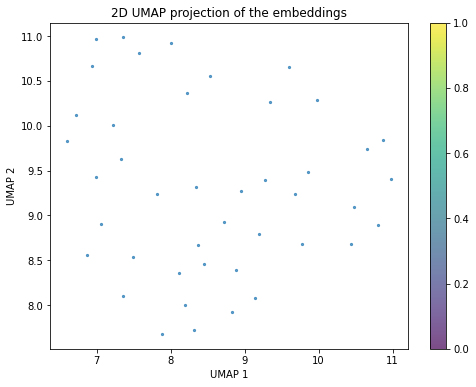

Embedding saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/embedding.npy


In [255]:
import matplotlib.pyplot as plt

# 可视化 embedding 的二维散点图
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', alpha=0.7)
plt.title('2D UMAP projection of the embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

print(f"Embedding saved to {output_path}")

In [256]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 读取数据
data_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'
data = np.load(data_path)

# 读取 comment token 长度
comment_index_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/comment_index.json'
with open(comment_index_path, 'r') as f:
    comment_length = len(json.load(f))

# 拆分 data 成 comment 和 code token
comments = data[:comment_length]
code_tokens = data[comment_length:]

# 计算相似度函数（使用余弦相似度）
def compute_similarity(tokens_a, tokens_b):
    return cosine_similarity(tokens_a, tokens_b)

# intra 相似度计算
intra_comment_sim = compute_similarity(comments, comments)
intra_code_sim = compute_similarity(code_tokens, code_tokens)

# inter 相似度计算
inter_comment_code_sim = compute_similarity(comments, code_tokens)
inter_code_comment_sim = compute_similarity(code_tokens, comments)

# 获取前 k 个最近邻
k = 12
def get_top_k_indices(sim_matrix, k):
    return np.argsort(-sim_matrix, axis=1)[:, :k]  # 获取前 k 个索引

# intra 计算
def get_intra_neighbors(sim_matrix, k, offset=0):
    neighbors = []
    for i in range(len(sim_matrix)):
        # 获取当前样本对其他样本的相似度排序
        sorted_indices = np.argsort(-sim_matrix[i])
        # 如果样本数量不足k个，用自身的索引补齐
        if len(sorted_indices) < k:
            needed = k - len(sorted_indices)
            neighbors.append(np.concatenate([
                sorted_indices + offset,
                np.array([i + offset] * needed)
            ]))
        else:
            neighbors.append(sorted_indices[:k] + offset)
    return np.array(neighbors)

intra_comment_neighbors = get_intra_neighbors(intra_comment_sim, k)
intra_code_neighbors = get_intra_neighbors(intra_code_sim, k, comment_length)

# inter 计算
inter_comment_neighbors = get_top_k_indices(inter_comment_code_sim, k) + comment_length  # comment 对 code 的相似度

# code 对 comment 的相似度，需要处理 comment 长度不足的情况
def get_code_to_comment_neighbors(sim_matrix, k, comment_length):
    neighbors = []
    for i in range(len(sim_matrix)):
        # 获取当前代码对所有注释的相似度排序
        sorted_indices = np.argsort(-sim_matrix[i])
        # 如果注释数量不足k个，用代码自身的索引补齐
        if len(sorted_indices) < k:
            needed = k - len(sorted_indices)
            neighbors.append(np.concatenate([
                sorted_indices,
                np.array([i + comment_length] * needed)
            ]))
        else:
            neighbors.append(sorted_indices[:k])
    return np.array(neighbors)

inter_code_neighbors = get_code_to_comment_neighbors(inter_code_comment_sim, k, comment_length)

# 拼接 intra 和 inter 结果
intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)


In [257]:

# 保存结果到文件
save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1'
intra_path = os.path.join(save_dir, "intra_similarity.npy")
inter_path = os.path.join(save_dir, "inter_similarity.npy")

np.save(intra_path, intra_neighbors)
np.save(inter_path, inter_neighbors)

# print(f"Intra neighbors saved to {intra_path}")
# print(f"Inter neighbors saved to {inter_path}")


In [258]:
ori_valid_code_attention_output_path = os.path.join("/home/yiming/cophi/training_dynamic/features/aa_possim", 'valid_code_attention_aa.npy')
ori_valid_nl_attention_output_path = os.path.join("/home/yiming/cophi/training_dynamic/features/aa_possim", 'valid_nl_attention_aa.npy')
ori_valid_code_attention_feature = np.load(ori_valid_code_attention_output_path)
ori_valid_nl_attention_feature = np.load(ori_valid_nl_attention_output_path)

In [259]:
import numpy as np
from collections import deque
from IPython.display import display, HTML

array = ori_valid_nl_attention_feature[comment_id]
array = array[1:]

token_list1 = nl_tokens_data[comment_id][1:]
doc_snippet = comment_dataset[comment_id]["docstring"]
normalized_contributions = (array - array.min()) / (array.max() - array.min())

# 将 token 与对应的贡献值配对，并去掉 token 中的 "Ġ" 符号
tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list1, normalized_contributions)])

# 生成HTML带字体大小的输出
html_string = "<pre>"
buffer = ""

# 遍历原始代码片段的每个字符
for char in doc_snippet:
    if char == "\n":
        # 遇到换行符则添加 <br> 标签并清空缓冲区
        html_string += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        # 获取当前 token 和其贡献值
        token, contrib = tokens_with_contributions[0]
        buffer += char

        # 逐字符匹配：检查 token 是否与 buffer 逐字符匹配
        if buffer == token:
            # 将贡献值映射到字体大小范围 [8, 16]
            font_size = 8 + (16 - 8) * contrib
            html_string += f'<span style="font-size: {font_size}px;">{buffer}</span>'
            buffer = ""  # 清空缓冲区
            tokens_with_contributions.popleft()  # 移除已匹配的 token
        elif not token.startswith(buffer):
            # 如果缓冲区字符序列和当前 token 不匹配，将缓冲区第一个字符添加到 HTML 并继续逐字符匹配
            html_string += buffer[0]
            buffer = buffer[1:]      
        
    else:
        # 如果没有更多 token 需要匹配，默认输出字符
        html_string += char

html_string += buffer  # 添加剩余的缓冲区内容
html_string += "</pre>"

# 在Jupyter Notebook中显示带有字体大小的文本
display(HTML(html_string))

In [260]:
# 假设我们有原始代码片段和分词后的 tokens（包含缩进和换行）
code_snippet = remove_docstrings(code_dataset[code_ind]["code"])
token_list2 = code_tokens_data[code_ind][1:]

# 假设注意力特征数组 (示例)
code_attention_feature = ori_valid_code_attention_feature[code_ind][1:]  # 模拟的注意力分数

# 归一化注意力特征
code_normalized_contributions = (code_attention_feature - code_attention_feature.min()) / (code_attention_feature.max() - code_attention_feature.min())

# 将 token 与对应的贡献值配对，并去掉 token 中的 "Ġ" 符号
tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list2, code_normalized_contributions)])

# 生成HTML带字体大小的输出
html_string = "<pre>"
buffer = ""

# 遍历原始代码片段的每个字符
for char in code_snippet:
    if char == "\n":
        # 遇到换行符则添加 <br> 标签并清空缓冲区
        html_string += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        # 获取当前 token 和其贡献值
        token, contrib = tokens_with_contributions[0]
        buffer += char

        # 逐字符匹配：检查 token 是否与 buffer 逐字符匹配
        if buffer == token:
            # 将贡献值映射到字体大小范围 [8, 16]
            font_size = 8 + (16 - 8) * contrib
            html_string += f'<span style="font-size: {font_size}px;">{buffer}</span>'
            buffer = ""  # 清空缓冲区
            tokens_with_contributions.popleft()  # 移除已匹配的 token
        elif not token.startswith(buffer):
            # 如果缓冲区字符序列和当前 token 不匹配，将缓冲区第一个字符添加到 HTML 并继续逐字符匹配
            html_string += buffer[0]
            buffer = buffer[1:]      
        
    else:
        # 如果没有更多 token 需要匹配，默认输出字符
        html_string += char

html_string += buffer  # 添加剩余的缓冲区内容
html_string += "</pre>"

# 在Jupyter Notebook中显示带有字体大小的文本
display(HTML(html_string))

In [261]:
comment_sorted_indices = np.argsort(-intra_comment_sim)
# 遍历每一行的排序索引，并输出排序后的 comment_data
for row_idx, sorted_indices in enumerate(comment_sorted_indices):
    sorted_comments = [comment_data[i] for i in sorted_indices]
    sorted_similarities = [intra_comment_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {comment_data[row_idx]} most similar comments:")
    for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar comments:
  Rank 1: <s> (Similarity: 1.0000)
  Rank 2: Ġ. (Similarity: 0.4625)
  Rank 3: Ġthe (Similarity: 0.4510)
  Rank 4: Ġthe (Similarity: 0.4118)
  Rank 5: Ġto (Similarity: 0.3867)
  Rank 6: Ġdictionary (Similarity: 0.3732)
  Rank 7: Ġcredentials (Similarity: 0.3619)
  Rank 8: Save (Similarity: 0.3532)

Row Save most similar comments:
  Rank 1: Save (Similarity: 1.0000)
  Rank 2: Ġcredentials (Similarity: 0.7284)
  Rank 3: Ġdictionary (Similarity: 0.6709)
  Rank 4: Ġto (Similarity: 0.4460)
  Rank 5: Ġ. (Similarity: 0.3865)
  Rank 6: <s> (Similarity: 0.3532)
  Rank 7: Ġthe (Similarity: 0.3437)
  Rank 8: Ġthe (Similarity: 0.3036)

Row Ġthe most similar comments:
  Rank 1: Ġthe (Similarity: 1.0000)
  Rank 2: Ġthe (Similarity: 0.6769)
  Rank 3: Ġto (Similarity: 0.5497)
  Rank 4: Ġ. (Similarity: 0.4991)
  Rank 5: <s> (Similarity: 0.4510)
  Rank 6: Ġcredentials (Similarity: 0.4355)
  Rank 7: Ġdictionary (Similarity: 0.3615)
  Rank 8: Save (Similarity: 0.3437)

Row Ġ

In [262]:
code_sorted_indices = np.argsort(-intra_code_sim)
# 遍历每一行的排序索引，并输出排序后的 code_data
for row_idx, sorted_indices in enumerate(code_sorted_indices):
    sorted_code = [code_data[i] for i in sorted_indices]
    sorted_similarities = [intra_code_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {code_data[row_idx]} most similar codes:")
    for idx, (comment, similarity) in enumerate(zip(sorted_code, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment, sorted_indices[idx]} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar codes:
  Rank 1: ('<s>', 0) (Similarity: 1.0000)
  Rank 2: ('Ġ(', 5) (Similarity: 0.4588)
  Rank 3: ('Ġ)', 9) (Similarity: 0.3934)
  Rank 4: ('Ġ=', 32) (Similarity: 0.3903)
  Rank 5: ('Ġ]', 31) (Similarity: 0.3610)
  Rank 6: ('Ġ:', 10) (Similarity: 0.3549)
  Rank 7: ('Ġself', 27) (Similarity: 0.3498)
  Rank 8: ('Ġ=', 13) (Similarity: 0.3488)
  Rank 9: ('Ġ.', 22) (Similarity: 0.3445)
  Rank 10: ('Ġ(', 19) (Similarity: 0.3430)
  Rank 11: ('Ġ.', 28) (Similarity: 0.3427)
  Rank 12: ('Ġ)', 20) (Similarity: 0.3424)
  Rank 13: ('Ġ[', 26) (Similarity: 0.3423)
  Rank 14: ('Ġ.', 15) (Similarity: 0.3294)
  Rank 15: ('Ġ_', 23) (Similarity: 0.3214)
  Rank 16: ('Ġserial', 33) (Similarity: 0.3189)
  Rank 17: ('Ġself', 21) (Similarity: 0.3163)
  Rank 18: ('Ġ_', 29) (Similarity: 0.3162)
  Rank 19: ('ized', 34) (Similarity: 0.3156)
  Rank 20: ('_', 17) (Similarity: 0.3151)
  Rank 21: ('key', 30) (Similarity: 0.3112)
  Rank 22: ('_', 3) (Similarity: 0.3089)
  Rank 23: ('Ġto', 16) (Si

In [263]:
print(np.max(inter_comment_code_sim))  # 输出最大值
print(np.min(inter_comment_code_sim))  # 输出最小值
print(np.max(intra_comment_sim))
print(np.min(intra_comment_sim))
print(np.max(intra_code_sim))
print(np.min(intra_code_sim))

0.8391568
-0.08918694
1.0
0.29078928
1.0000005
-0.1469279


In [264]:
comment_sorted_indices = np.argsort(-inter_comment_code_sim)
# 遍历每一行的排序索引，并输出排序后的 comment_data
for row_idx, sorted_indices in enumerate(comment_sorted_indices):
    sorted_comments = [code_data[i] for i in sorted_indices]
    sorted_similarities = [inter_comment_code_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {comment_data[row_idx]} most similar codes:")
    for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment, sorted_indices[idx]} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar codes:
  Rank 1: ('<s>', 0) (Similarity: 0.7333)
  Rank 2: ('Ġ(', 5) (Similarity: 0.4172)
  Rank 3: ('Ġ=', 32) (Similarity: 0.3767)
  Rank 4: ('Ġ=', 13) (Similarity: 0.3510)
  Rank 5: ('Ġ.', 22) (Similarity: 0.3496)
  Rank 6: ('Ġ[', 26) (Similarity: 0.3493)
  Rank 7: ('Ġ(', 19) (Similarity: 0.3489)
  Rank 8: ('Ġ]', 31) (Similarity: 0.3453)
  Rank 9: ('Ġ.', 15) (Similarity: 0.3400)
  Rank 10: ('Ġ)', 20) (Similarity: 0.3366)
  Rank 11: ('Ġ.', 28) (Similarity: 0.3353)
  Rank 12: ('Ġself', 27) (Similarity: 0.3218)
  Rank 13: ('_', 3) (Similarity: 0.3071)
  Rank 14: ('_', 17) (Similarity: 0.3009)
  Rank 15: ('Ġcredentials', 14) (Similarity: 0.2974)
  Rank 16: ('key', 30) (Similarity: 0.2963)
  Rank 17: ('Ġserial', 33) (Similarity: 0.2961)
  Rank 18: ('ized', 34) (Similarity: 0.2959)
  Rank 19: ('Ġto', 16) (Similarity: 0.2934)
  Rank 20: ('Ġ_', 23) (Similarity: 0.2908)
  Rank 21: ('d', 24) (Similarity: 0.2898)
  Rank 22: ('ictionary', 25) (Similarity: 0.2895)
  Rank 23: 

In [265]:
import numpy as np

# 文件路径
train_nl_tokens_path = '/home/yiming/cophi/training_dynamic/features/aa_possim/train_nl_tokens_aa.npy'

# 读取nl_tokens.npy
all_train_nl_tokens = np.load(train_nl_tokens_path)


In [266]:
train_token_1 = all_train_nl_tokens[1][9]
valid_token_1 = nl_tokens[3]
sim = compute_similarity(train_token_1.reshape(1, -1), valid_token_1.reshape(1, -1))
print(sim)

[[0.8265128]]
